In [1]:
from src.sift import *
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def build_A(num, pairs,i):

    A = np.zeros((2*num,9))

    A[:num,0] = pairs[0][i,0]
    A[:num,1] = pairs[0][i,1]
    A[:num,2] = np.ones(num)

    A[:num,6] = -1*pairs[1][i,0]*pairs[0][i,0]
    A[:num,7] = -1*pairs[1][i,0]*pairs[0][i,1]
    A[:num,8] = -1*pairs[1][i,0]


    A[num:,3] = -pairs[0][i,0]
    A[num:,4] = -pairs[0][i,1]
    A[num:,5] = -np.ones(num)

    A[num:,6] = 1*pairs[1][i,1]*pairs[0][i,0]
    A[num:,7] = 1*pairs[1][i,1]*pairs[0][i,1]
    A[num:,8] = 1*pairs[1][i,1]
    return A


In [3]:
def Homography(pairs,num=4):
    idx = np.arange(pairs[0].shape[0])

    i = np.random.choice(idx,num)
    


    A = build_A(num,pairs,i)

    U,S,V = np.linalg.svd(A)

    h = V[-1]

    e = homography_error(pairs,h)
    
    return h,e,pairs[0][i],pairs[1][i]

In [4]:
def homography_error(pairs,h):

    H = np.reshape(h,(3,3))

    x0 = np.vstack((pairs[0][:,:2].T,np.ones(pairs[0].shape[0])))
    x2 = np.vstack((pairs[1][:,:2].T,np.ones(pairs[1].shape[0])))

    x1_ = H.dot(x0)

    x1_ = np.divide(x1_[:2,:],x1_[2,:],out=np.zeros_like(x1_[:2,:]),
                    where=x1_[2,:]!=0)


    x2_ = (H.T).dot(x2)
    x2_ = np.divide(x2_[:2,:],x2_[2,:],out=np.zeros_like(x2_[:2,:]),
                    where=x2_[2,:]!=0)

    return np.sum(( pairs[1][:,:2].T - x1_)**2,axis=0) #+ np.sum((x2_ - pairs[0][:,:2].T)**2,axis=0)


# Random Sample Consensus - RANSAC

Likelihood that S trials will fail:
$$1-P=(1-p^k)^s$$

For a given probability of having inliers, the required minimum number of trials S is:
$$S = \frac{log(1-P)}{log(1-p^k)}$$

In [5]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC(im1,im2,pairs,min_pts=4,p=0.1,P=.98,th=100,type_='affine'):
    
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
    
    best_fit=0
    
    for i in range(S):
        if type_=='affine':
            w,e,x1,x2 = Affine(pairs,min_pts)
        else:
            w,e,x1,x2 = Homography(pairs,min_pts)

        inliers = np.sum(e<th**2)

        if inliers>=best_fit:
            best_w = w
            best_e = np.sum(e)
            best_x1 = x1
            best_x2 = x2
            idx = e<th**2
            best_fit = inliers
            

    best_x1 = pairs[0][idx]
    best_x2 = pairs[1][idx]


    print("Ransac affine/homography best matches:")

    plt.imshow(im1,**{'cmap':'gray'})

    plt.scatter(best_x1[:,1],best_x1[:,0],c='red',s=10)

    for i in range(len(pairs[0][idx])):
        plt.text(best_x1[i,1],best_x1[i,0],str(i),withdash=False,**{'color':'red'})


    plt.show()

    plt.imshow(im2,**{'cmap':'gray'})
    plt.scatter(best_x2[:,1],best_x2[:,0],c='red',s=10)


    for i in range(len(pairs[0][idx])):
        plt.text(best_x2[i,1],best_x2[i,0],str(i),withdash=False,**{'color':'red'})

    plt.show()
    print("RANSAC number of inlers: {}".format(best_fit))

    
    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    else:
        H = np.reshape(best_w,(3,3))
        
    return H,idx

In [6]:
import multiprocessing as mp

def worker(kwargs):
    return sift(**kwargs)

def match_kps(kwargs1,kwargs2,NUM_CORE=6):
    
    pool = mp.Pool(NUM_CORE)

    start = time.time()

    list_of_results = pool.map(worker, (kwargs1,kwargs2))

    im1,im2 = list_of_results
    im1==im2
    end = time.time()
    print("total time: {}".format(end-start))
    return im1,im2

## Use sift to get interest points and putative correspondences:

In [36]:
kwargs1 = {'img1_':os.path.abspath('img/house/house7.jpg'),'N':2,'Red':2,'s':3,'crt':0.8,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}
kwargs2 = {'img1_':os.path.abspath('img/house/house10.jpg'),'N':2,'Red':2,'s':3,'crt':0.8,'sig':1.6,'RANSAC_th':20,'RANSAC_p':0.3}

im1,im2 = match_kps(kwargs1,kwargs2)

time to get kps: 4.898568391799927
time to get kps: 5.5156638622283936
time to match: 4.658409118652344
total time: 10.54475212097168


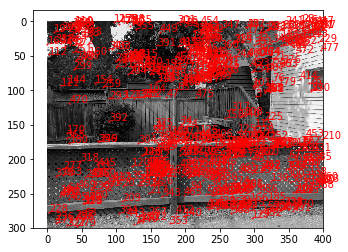

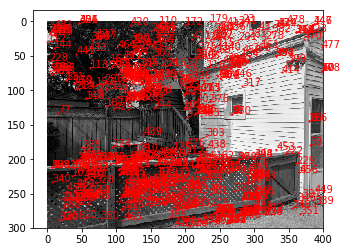

In [37]:
im1.plot('best_kp')
im2.plot('best_kp')

## RANSAC robust estimation

Ransac affine/homography best matches:


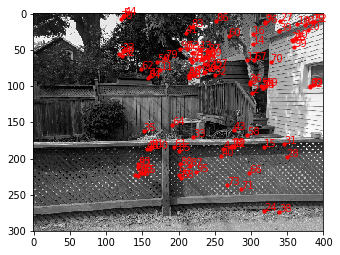

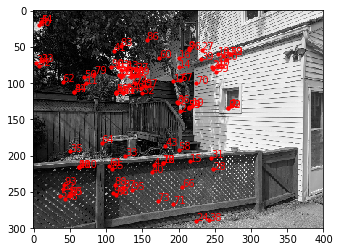

RANSAC number of inlers: 102


In [38]:
pairs = (im1.best_kp,im2.best_kp)

H,idx = RANSAC(im1.img1_,im2.img1_,pairs,4,type_="homography",p=0.1,P=.98,th=5)

## Refine w/ non liner optimization

In [39]:
def get_dist(H,x,x_):
    x1_ = H.dot(hmg(x_).T)


    x1_ = np.divide(x1_[:2,:],x1_[2,:],out=np.zeros_like(x1_[:2,:]),
                    where=x1_[2,:]!=0)

    d = x1_.T - x

    return np.sum(d**2,axis=1)



In [40]:
class optimizeH:
    def __init__(self,pairs,H,idx):
        self.pairs = pairs
        self.update_param(H,idx)
        
        
    def update_param(self,H,idx):
        
        self.idx = idx
        self.H0 = H        
        self.pairsx = self.pairs[0][idx],self.pairs[1][idx]
      
    def reproj_error(self,H0,pairs):
        
        H = np.reshape(H0,(3,3))
        
        d1 = get_dist(H,pairs[1][:,:2],pairs[0][:,:2])
        
        d2 = get_dist(np.linalg.inv(H),pairs[0][:,:2],pairs[1][:,:2])


        return d1 + d2

    def J(self,x0,pairs):
        fun = self.reproj_error
        step = 1e-4
        delta = np.zeros(x0.shape[0])    
        grad = []
        for i in np.arange(x0.shape[0]):

            delta[i] = step
            x2 = x0 + delta
            x1 = x0 - delta
            increment2 = fun(x2,pairs)
            increment1 = fun(x1,pairs)
            grad.append((increment2-increment1)/(2*step))
            delta[i] -= step  

        return np.array(grad).T
    
    def solve(self,factor=10):
        H0 = self.H0.flatten()
        
        j = self.J(H0,self.pairsx)
        
        N = j.T.dot(j)
        
        lamb = np.mean(np.diag(N))*1e-3

        ei = self.reproj_error(H0,self.pairsx)
        
        w = np.linalg.solve(N + lamb*np.diag(np.ones(9)),(-j.T).dot(ei))

        dif0 = self.reproj_error(H0 - w,self.pairsx) - ei
        
        dif0=dif0.T.dot(dif0)
                
        
        for i in range(100):

            j = self.J(H0,self.pairsx)
            N = j.T.dot(j)
            ei = self.reproj_error(H0,self.pairsx)
            w = np.linalg.solve(N + lamb*np.diag(np.ones(9)),(-j.T).dot(ei))
            dif = self.reproj_error(H0-w,self.pairsx) - ei
            dif = dif.T.dot(dif)

            if dif<dif0:
                lamb/=factor
                dif0=dif
                H0 -= w
                
            else:
                lamb*=factor
        
        self.H_ = np.reshape(H0,(3,3))
        
        return self.H_
    
    def iter_solve(self,niter=10,factor=10,th=3,diag=False):
        new_idx = self.idx
        init_inliers = np.sum(self.idx)
        best_inliers = 0
        ninliers = []
        Hi = self.H0
        
        for i in range(niter):
            self.update_param(Hi,new_idx)
            
            Hi = self.solve()

            e = self.reproj_error(Hi,self.pairs)
            
            new_idx = e<2*th**2
            
            inliers = np.sum(new_idx)
            ninliers.append(inliers)
            
            if best_inliers<inliers:
                best_H = Hi
                best_idx = new_idx
                best_inliers = inliers
            
            if diag==True:print("# inliers: {}".format(inliers))

        print("Initial n of inliers: {}".format(init_inliers))
        print("Final n of inliers: {}".format(ninliers[-1]))
        print("Best inliers: {}".format(best_inliers))
        return best_H,best_idx


In [41]:
aa = optimizeH(pairs,H,idx)
H_,idx_ = aa.iter_solve(niter=10,th=5,diag=True)

# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
# inliers: 102
Initial n of inliers: 102
Final n of inliers: 102
Best inliers: 102


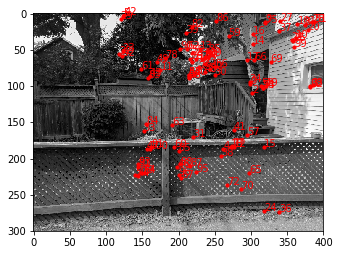

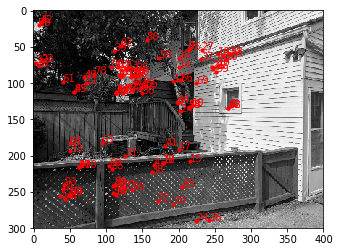

In [42]:
best_x1 = pairs[0][idx_]
best_x2 = pairs[1][idx_]

plt.imshow(im1.img1_,**{'cmap':'gray'})

plt.scatter(best_x1[:,1],best_x1[:,0],c='red',s=10)

for i in range(len(pairs[0][idx_])):
    plt.text(best_x1[i,1],best_x1[i,0],str(i),withdash=False,**{'color':'red'})


plt.show()

plt.imshow(im2.img1_,**{'cmap':'gray'})
plt.scatter(best_x2[:,1],best_x2[:,0],c='red',s=10)


for i in range(len(pairs[0][idx_])):
    plt.text(best_x2[i,1],best_x2[i,0],str(i),withdash=False,**{'color':'red'})

plt.show()


In [56]:
from skimage.transform import warp
import skimage.transform as tf
from skimage.transform import ProjectiveTransform

def warped_imgs(im1,im2,H_):
    
    plt.imshow(im1.img1_)
    plt.show()
    
    A = warp(im1.img1_,ProjectiveTransform(matrix=H_),clip=False)

    plt.imshow(A)
    plt.show()
    plt.imshow(im2.img1_)
    plt.show()
    pass


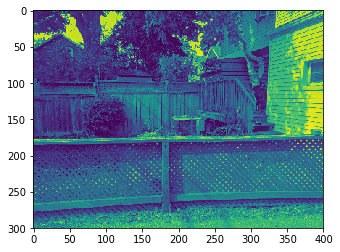

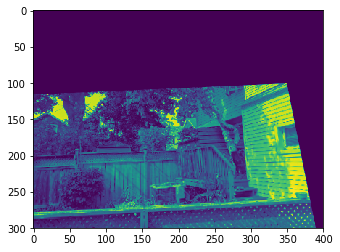

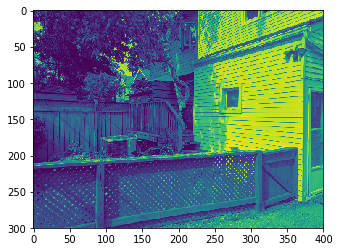

In [57]:
warped_imgs(im1,im2,H_)